In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from starwinds_magnetogram import reader_writer
from starwinds_magnetogram import converter
from starwinds_magnetogram import rotate
from starwinds_magnetogram import plots
from starwinds_magnetogram import plot_pfss
from starwinds_magnetogram import plot_zdi
from starwinds_magnetogram import coefficients
from starwinds_magnetogram import zdi_magnetogram
from starwinds_magnetogram import geometry
from starwinds_magnetogram import pfss_magnetogram

# Building a PFSS magnetogram from scratch

Corners in pcolormesh not specified. Falling back to nearest shading.
Corners in pcolormesh not specified. Falling back to nearest shading.
Corners in pcolormesh not specified. Falling back to nearest shading.


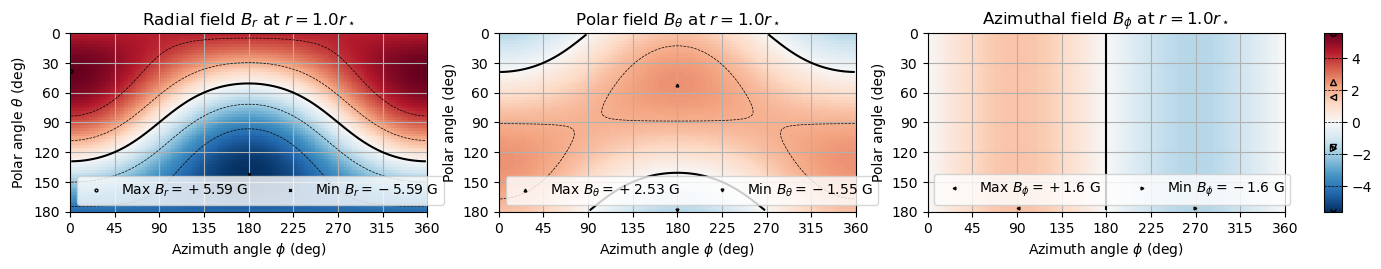

In [2]:
coeffs = coefficients.Coefficients()

# Start with a rotated dipole
coeffs.append(1, 0, 5.0)
coeffs = rotate.rotate_magnetogram_euler_zyz_deg(coeffs, (0, 30, 0))
coeffs = converter.map_to_positive_orders(coeffs)
fig, axs = plt.subplots(1,3, figsize=(18, 5))
plot_pfss.plot_components(coeffs, axs=axs)
plt.show()

Corners in pcolormesh not specified. Falling back to nearest shading.
Corners in pcolormesh not specified. Falling back to nearest shading.
Corners in pcolormesh not specified. Falling back to nearest shading.


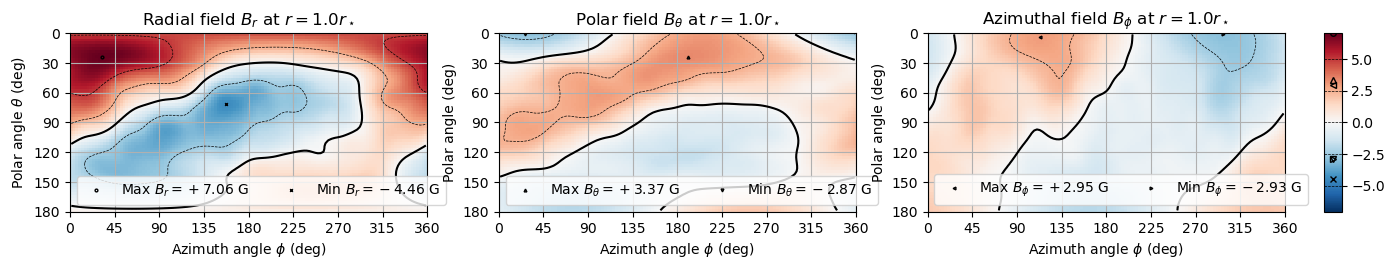

In [3]:
# Add some noise
noise = coefficients.noise(degree_max=15, beta=1) * 10
coeffs += noise
fig, axs = plt.subplots(1,3, figsize=(18, 5))
plot_pfss.plot_components(coeffs, axs=axs)
plt.show()

In [4]:
reader_writer.write_magnetogram_file(coeffs, 
                                     file_name="my-magnetogram.dat", 
                                     degree_max=None,
                                     write_swmf_header=False,
                                    )
!head my-magnetogram.dat
del coeffs

Output of /Users/dagevensberget/Documents/starwinds-split/starwinds-magnetogram/starwinds_magnetogram/reader_writer.py
Order:15
  0    0   0.000000e+00   0.000000e+00
  1    0   1.778336e+00   2.255030e+00
  1    1   2.409657e+00  -6.799746e-01
  2    0   2.272388e+00   3.409032e-01
  2    1   2.513749e+00   2.299662e+00
  2    2   7.150088e-01  -9.720378e-02
  3    0   4.464750e-01   1.483551e-01
  3    1  -4.765548e-01   4.502565e-01


## Load the PFSS magnetogram back in

Corners in pcolormesh not specified. Falling back to nearest shading.
Corners in pcolormesh not specified. Falling back to nearest shading.
Corners in pcolormesh not specified. Falling back to nearest shading.


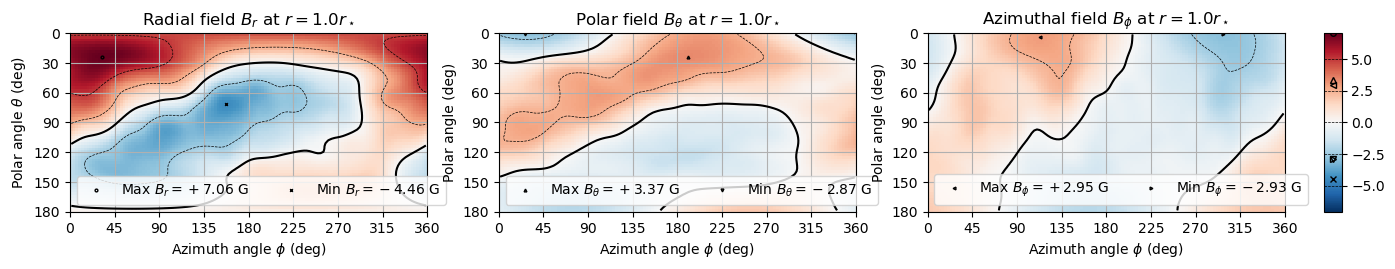

In [5]:
file = "my-magnetogram.dat"
coeffs = reader_writer.read_magnetogram_file(file)
fig, axs = plt.subplots(1,3, figsize=(18, 5))
plot_pfss.plot_components(coeffs, axs=axs)
plt.show()

# Rotating a PFSS magnetogram
The PFSS magnetogram is entirely determined by the radial coefficients, so it should not be surprising that the polar and azimuthal coefficients change when the radial coefficients are rotated.

Corners in pcolormesh not specified. Falling back to nearest shading.
Corners in pcolormesh not specified. Falling back to nearest shading.
Corners in pcolormesh not specified. Falling back to nearest shading.


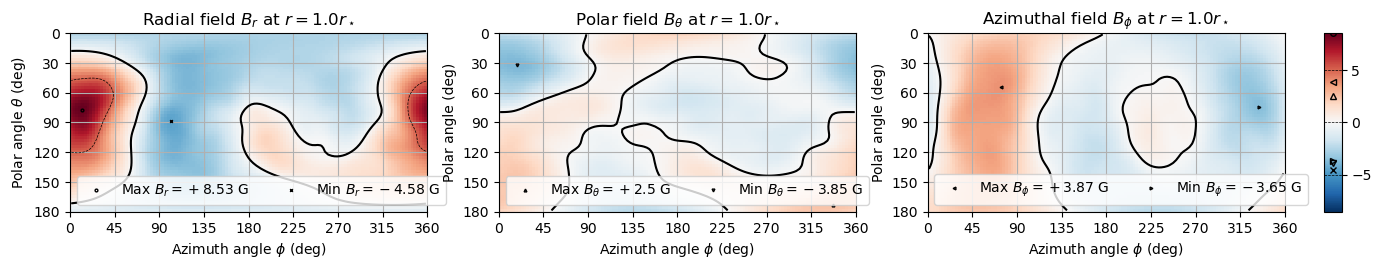

In [6]:
rotated = rotate.rotate_magnetogram_euler_zyz_deg(coeffs, (0, 60, 0))
rotated = converter.map_to_positive_orders(rotated)
fig, axs = plt.subplots(1,3, figsize=(18, 5))
plot_pfss.plot_components(rotated, axs=axs)
plt.show()

## Converting to ZDI format

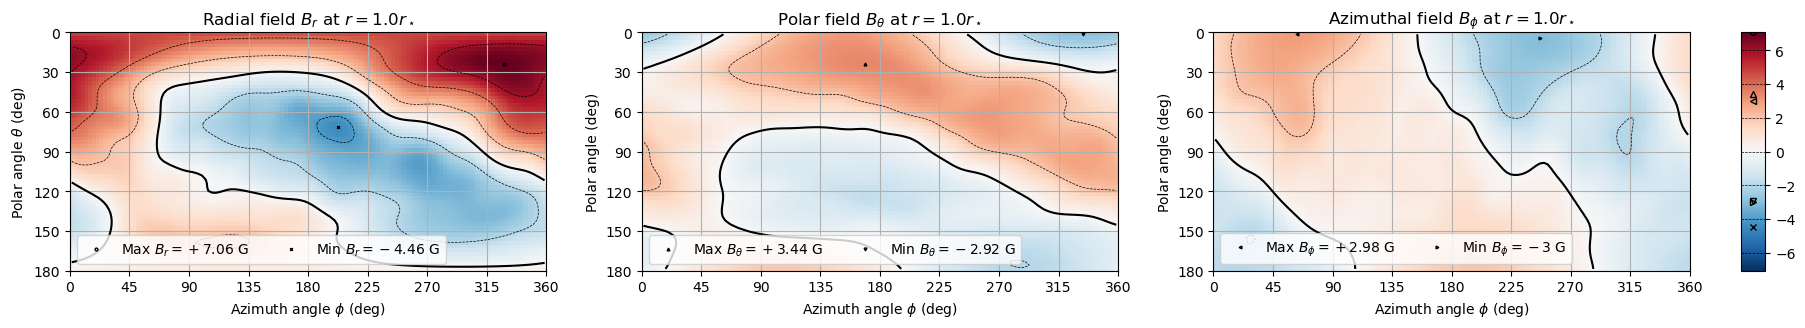

In [7]:
zdi_coeffs = zdi_magnetogram.from_coefficients(converter.convert_pfss_to_zdi(coeffs))
plot_zdi.plot_zdi_components(zdi_coeffs)
plt.show()

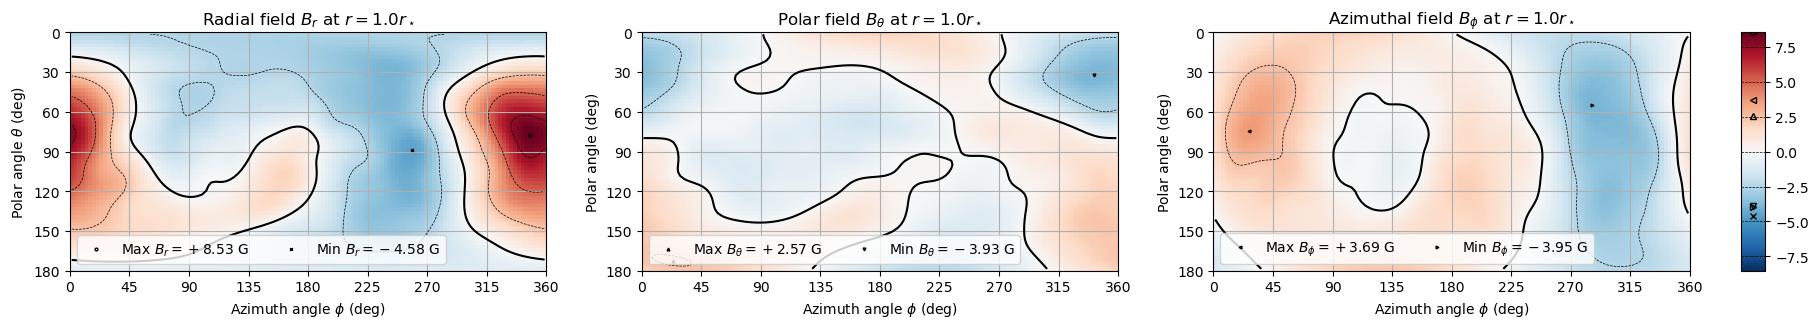

In [8]:
zdi_rotated = zdi_magnetogram.from_coefficients(converter.convert_pfss_to_zdi(rotated))
plot_zdi.plot_zdi_components(zdi_rotated)
plt.show()

Notice how while the energies of each harmonics $(\ell, m)$ are changed by the rotation, the total energy at each degree $\ell$ is as before.

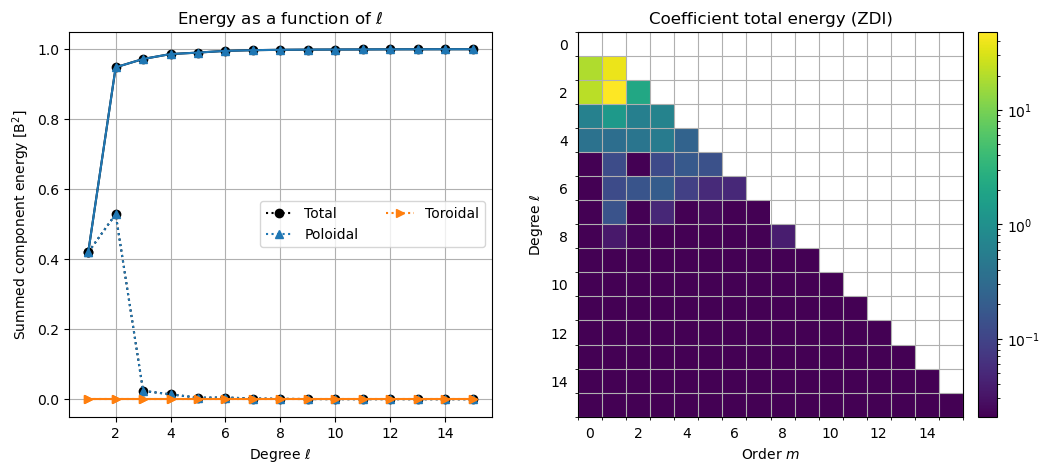

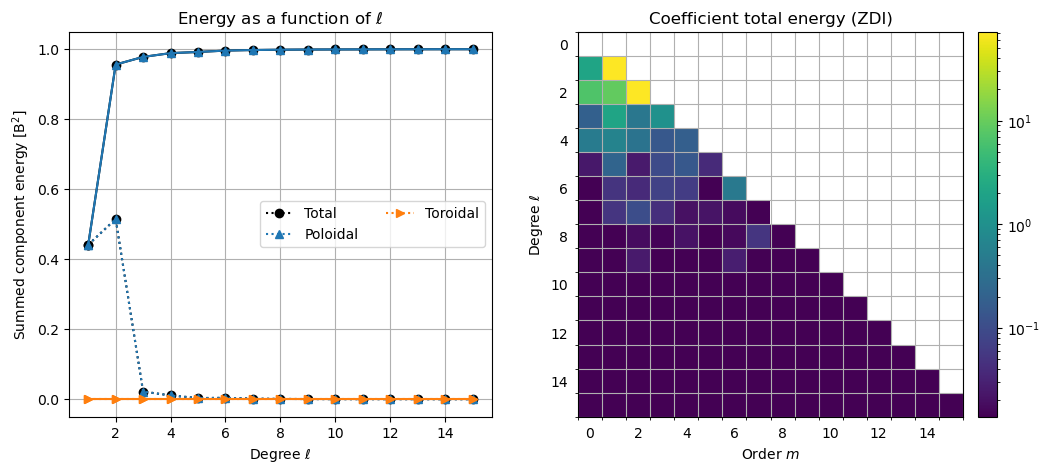

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
plot_zdi._plot_energy(zdi_coeffs, ax=axs[1])
plot_zdi.plot_energy_by_degree(zdi_coeffs, ax=axs[0])

fig, axs = plt.subplots(1,2, figsize=(12,5))
plot_zdi._plot_energy(zdi_rotated, ax=axs[1])
plot_zdi.plot_energy_by_degree(zdi_rotated, ax=axs[0]);

plt.show()

## Load an image 
For fun, read in an image and create a magnetogram from it.

In [10]:
import urllib.request
import IPython.display
import PIL.Image
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")
from starwinds_magnetogram import image_converter
image_converter.log.setLevel(logging.INFO)

url = 'https://svs.gsfc.nasa.gov/vis/a000000/a003400/a003487/landmask4K.png'
file, head = urllib.request.urlretrieve(url)

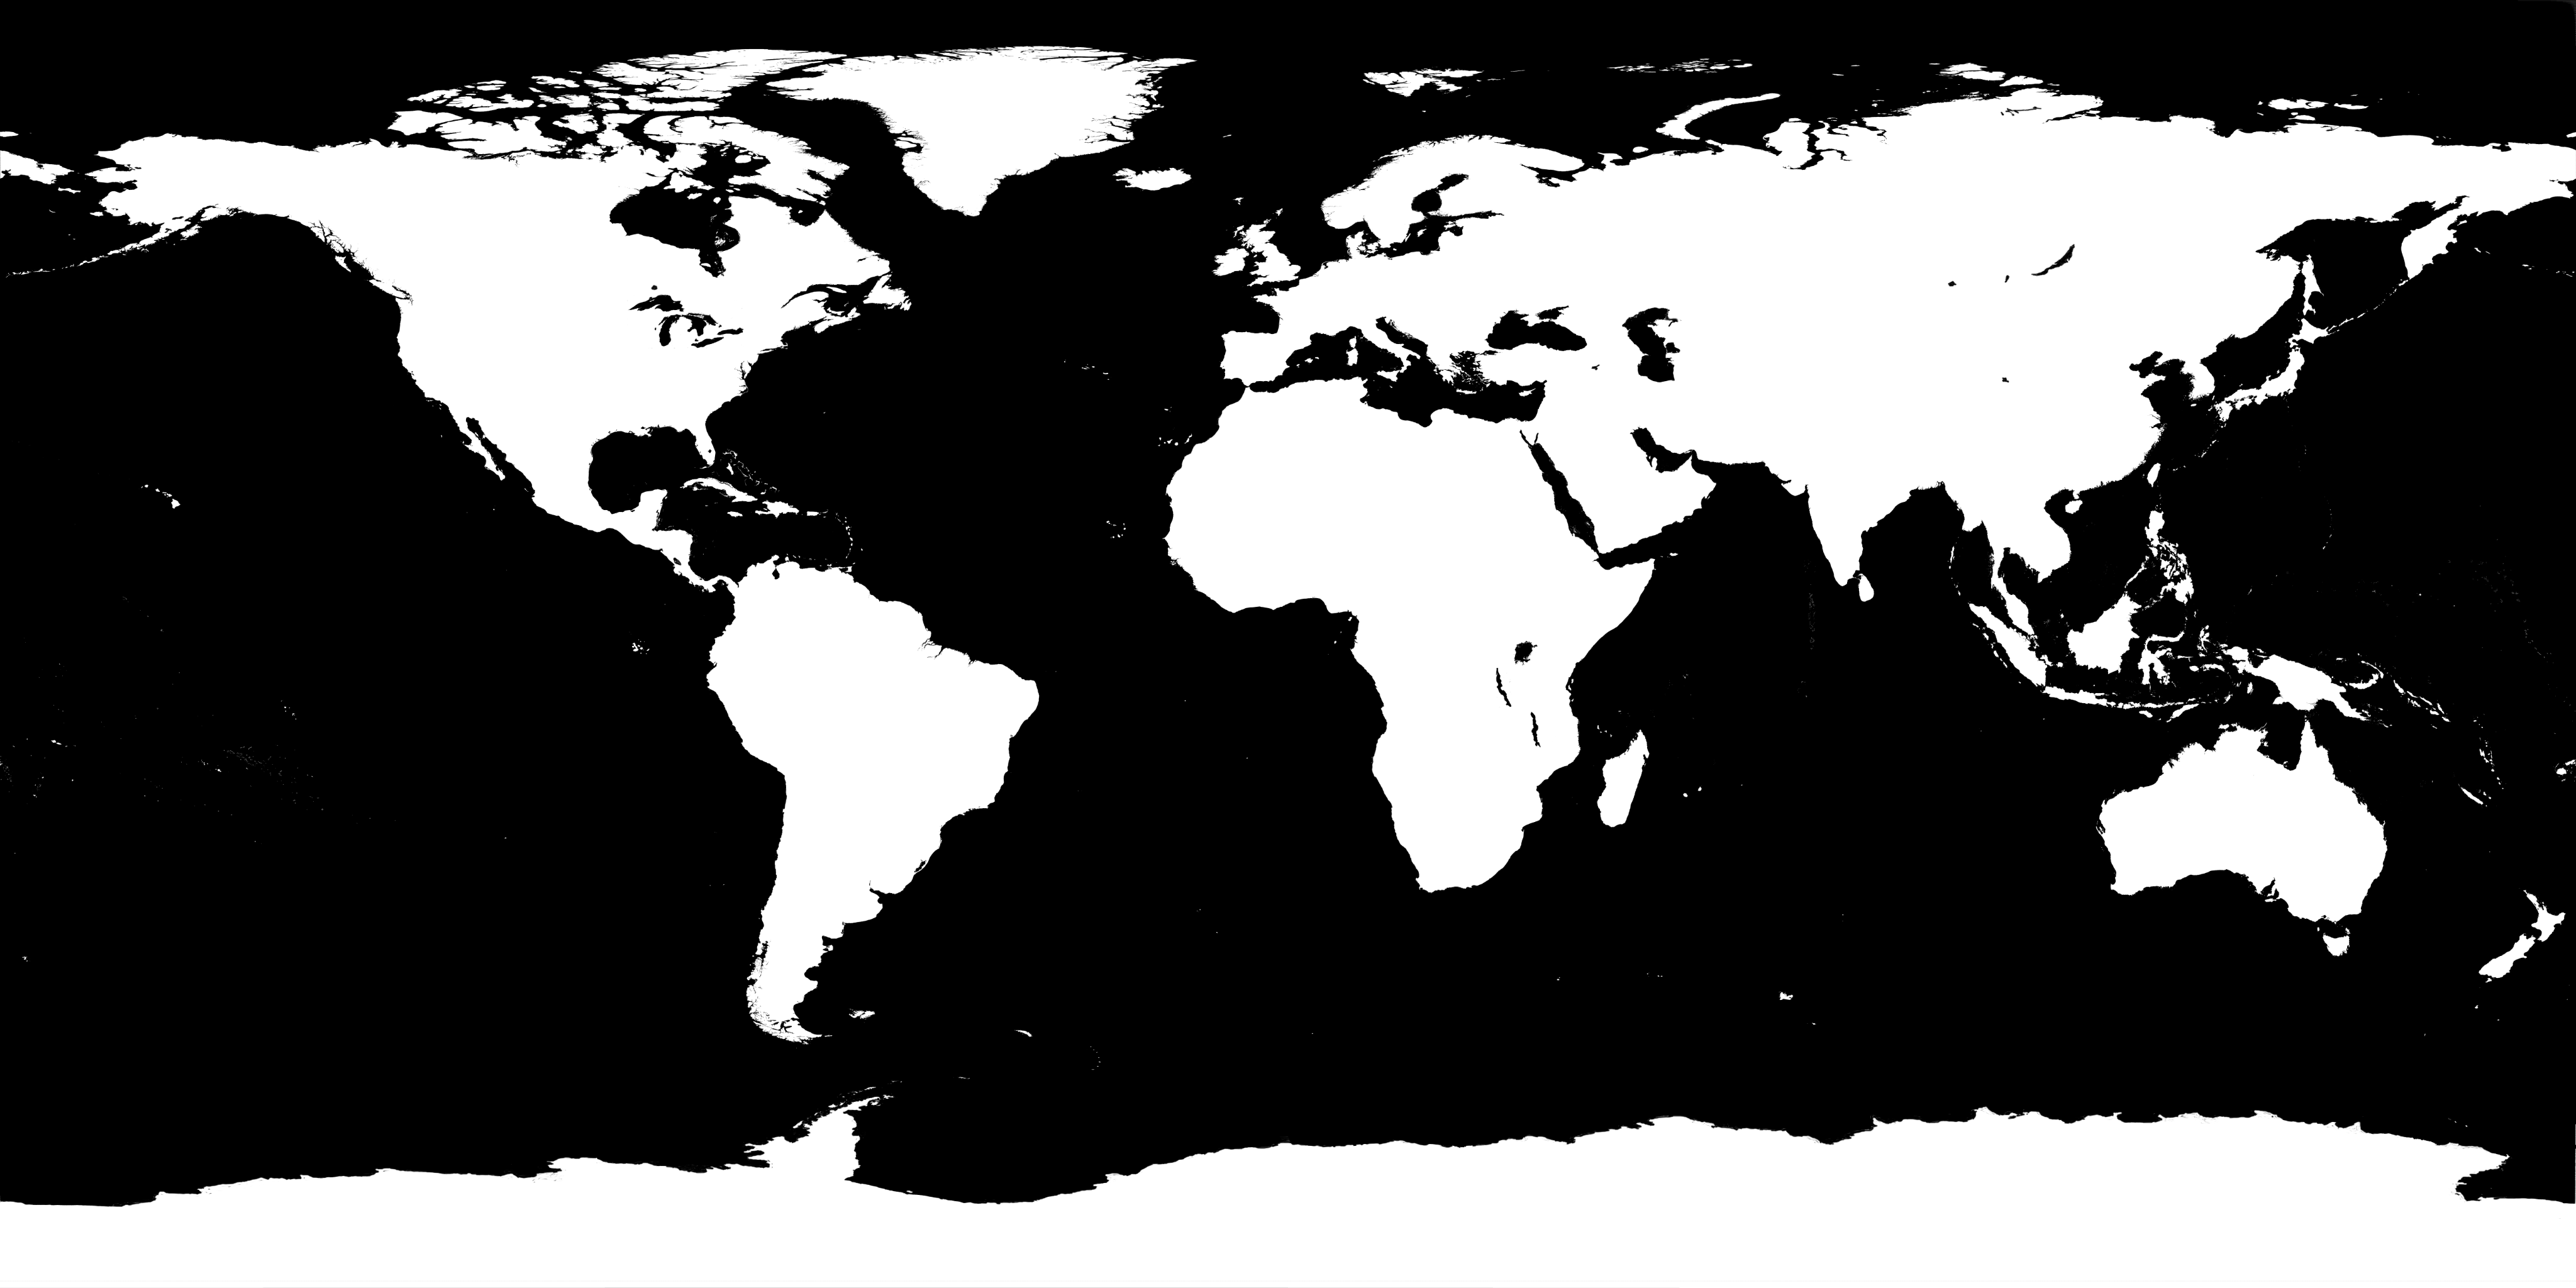

The image is (4096, 2048) pixels in size.


In [11]:
full_image = PIL.Image.open(file)
IPython.display.display(full_image)
print(f'The image is {full_image.size} pixels in size.')

The image is way too big so resize it to $4\ell_\text{max}$ in the longitude direction.

/var/folders/nv/0mgzj8b55p33mkl925j5cf0h0000gn/T/ipykernel_16553/1976362778.py:4: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = full_image.resize(new_size, PIL.Image.LANCZOS)


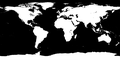

The resized image is (120, 60) pixels in size.


In [12]:
l_max = 30
resize_factor = full_image.size[0] // (4 * l_max)
new_size = [d // resize_factor for d in full_image.size]
image = full_image.resize(new_size, PIL.Image.LANCZOS)
IPython.display.display(image)
print(f'The resized image is {image.size} pixels in size.')

INFO:starwinds_magnetogram.image_converter:Built coefficients in 1.648238 seconds
INFO:starwinds_magnetogram.image_converter:Built image in 0.038017 seconds


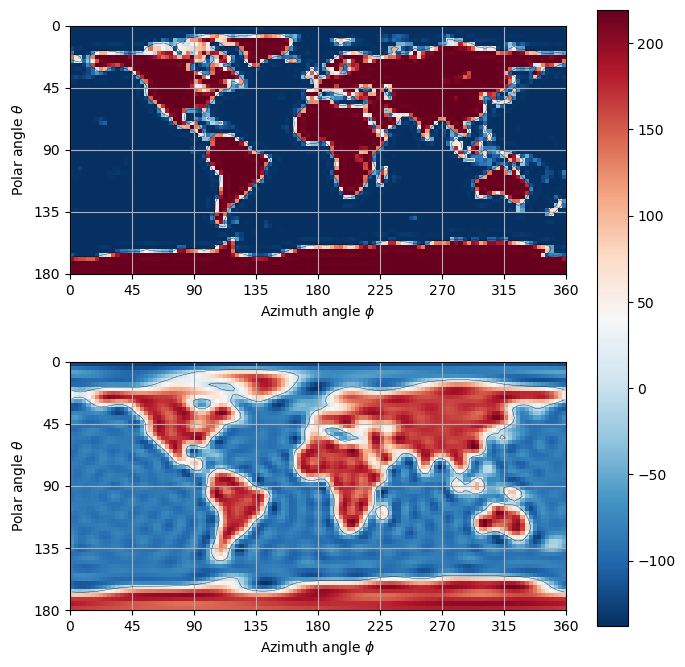

In [13]:
image_in = np.array(image)
while len(image_in.shape) > 2:
    print(image_in.shape)
    image_in = np.average(image_in, axis=2)
image_in = image_in.T - np.average(image_in)


coeffs, zg = image_converter.from_image(image_in, lmax=l_max)
image_out = np.real(image_converter.to_image(coeffs, zg))

vmax = np.maximum(np.max(image_in), np.max(image_out))
vmin = np.minimum(np.min(image_in), np.min(image_out))
v_max_abs = np.maximum(np.abs(vmax), np.abs(vmin))

fig, axs = plt.subplots(2, 1, figsize=(8, 8))

for data, ax in zip((image_in, image_out), axs):
    img = plots.plot_equirectangular(zg, np.real(data), ax)

cb = fig.colorbar(img, ax=axs.ravel().tolist())

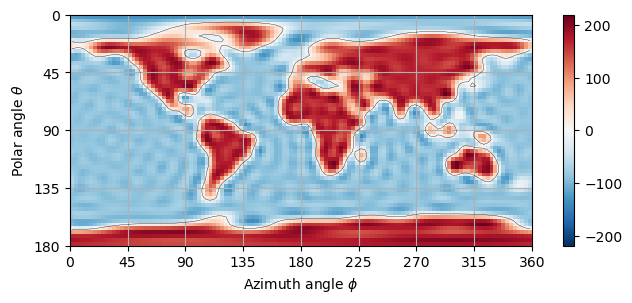

In [14]:
# A ZDI magnetogram usually does not have negative orders, so 
# transform the coefficients so that the negative orders are all zero.
# This changes the imaginary component of the magnetogram, which are
# anyhow ignored in ZDI.
coeffs = converter.map_to_positive_orders(coeffs)

# Create the ZDI magnetogram 
lz = zdi_magnetogram.from_coefficients(coeffs)
polar, azimuth = zg.corners()

# This only returns the real component since it is a ZDI magnetogram.
B = lz.get_radial_field(*zg.centers())

Bscale = np.max(np.abs(B))

fig, ax = plt.subplots(figsize=(8, 3))
img1 = plots.plot_equirectangular(zg, B,
                                  ax,
                                  vmin=-v_max_abs,
                                  vmax=v_max_abs,
                                 )

cb = fig.colorbar(img1, ax=ax)